# 04c - Classification Models Development

**Objetivo**: Desarrollar modelos de clasificación para predecir categorías de riesgo de Alzheimer (Low, Moderate, High)
 
**Target Variable**: `risk_category`
**Clases**: Low (46.4%), Moderate (46.1%), High (7.5%)
 
**Modelos a desarrollar**:
- Logistic Regression (baseline)
- Random Forest Classifier
- Gradient Boosting (XGBoost, LightGBM)
- Support Vector Machine
- Neural Network (MLP)

---

## Importar librerías

In [1]:
import sys
import os
sys.path.append('../src/modeling')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import mlflow
import mlflow.sklearn
from sklearn.model_selection import cross_validate
from sklearn.ensemble import StackingClassifier  # Import explícito por si acaso
import warnings
warnings.filterwarnings('ignore')

import model_utils
# Importar scripts personalizados
from classification_pipeline import ClassificationPipeline
from ensemble_methods import AlzheimerEnsemble

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [10]:
print("✅ Librerías y scripts importados correctamente")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ Librerías y scripts importados correctamente
📅 Fecha de ejecución: 2025-06-22 18:18:38


## Cargar datos

In [4]:
# Cargar datos procesados
try:
    df = pd.read_csv('../data/processed/features/alzheimer_features_selected_20250621.csv')
    print(f"📊 Dataset cargado: {df.shape}")
    
    # Verificar target variable
    if 'risk_category' in df.columns:
        print(f"🎯 Distribución de clases:")
        class_dist = df['risk_category'].value_counts()
        print(class_dist)
        print(f"📊 Porcentajes:")
        print((class_dist / len(df) * 100).round(1))
    else:
        print("❌ Error: Variable target 'risk_category' no encontrada")
        
except FileNotFoundError:
    print("❌ Error: Archivo de features no encontrado")
    print("💡 Ejecuta primero el notebook 03_feature_engineering_master.ipynb")


📊 Dataset cargado: (48466, 186)
🎯 Distribución de clases:
risk_category
Low         22501
Moderate    22345
High         3620
Name: count, dtype: int64
📊 Porcentajes:
risk_category
Low         46.4
Moderate    46.1
High         7.5
Name: count, dtype: float64


## Inicializar Pipeline de Clasificaión

In [5]:
# Inicializar pipeline de clasificación
classification_pipeline = ClassificationPipeline()

## Ejecutar Pipeline

In [6]:
# Ejecutar el pipeline completo
print("🚀 Ejecutando pipeline completo de clasificación...")
pipeline_results = classification_pipeline.run_pipeline(df, target_col='risk_category')

# Obtener resultados
results = pipeline_results['results']
cv_results = pipeline_results['cv_results']
trained_models = pipeline_results['trained_models']
best_model_name = pipeline_results['best_model']

print(f"🏆 Mejor modelo seleccionado: {best_model_name}")


🚀 Ejecutando pipeline completo de clasificación...
🚀 Iniciando pipeline de clasificación...
📊 Datos preparados: 38772 train, 9694 test
Entrenando logistic_regression...
Entrenando random_forest...
Entrenando gradient_boosting...
Entrenando svm...
   Usando subconjunto de 10000 muestras para SVM
✅ 4 modelos entrenados
📈 Evaluación completada
Validación cruzada para logistic_regression...
Validación cruzada para random_forest...
Validación cruzada para gradient_boosting...
Validación cruzada para svm...
🔄 Validación cruzada completada
🏆 Mejor modelo: gradient_boosting


2025/06/26 12:13:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


📁 Resultados registrados en MLflow
🏆 Mejor modelo seleccionado: gradient_boosting


3524 segundos de ejecución

## Recopilar métricas de rendimiento

In [7]:
# Recopilar métricas de rendimiento
performance_comparison = {}
for name, metrics in results.items():
    performance_comparison[name] = metrics['f1_weighted']

## Ensamblaje de modelos

In [8]:
with mlflow.start_run(run_name="ensemble_classification"):
    mlflow.set_tag("model_family", "ensemble")
    mlflow.set_tag("model_type", "classification")
    
    # 0. Reconstruir datos COMPLETOS desde cero
    X_train, X_test, y_train, y_test = classification_pipeline.prepare_data(df)
    X_full = pd.concat([X_train, X_test])
    y_full = pd.concat([y_train, y_test])
    
    # 1. Definir best_models usando los modelos entrenados
    best_models = {
        'logistic_regression': trained_models['logistic_regression'],
        'random_forest': trained_models['random_forest'],
        'gradient_boosting': trained_models['gradient_boosting'],
        'svm': trained_models['svm']
    }
    
    print("🚀 Creando modelos ensemble...")
    
    # 2. Inicializar ensemble
    ensemble = AlzheimerEnsemble()
    
    # 3. Crear ensembles personalizados
    voting_clf = ensemble.create_custom_voting_ensemble(best_models)
    stacking_clf = ensemble.create_custom_stacking_ensemble(best_models)
    
    # 4. Evaluar con cross_validate (para métricas consistentes)
    from sklearn.model_selection import cross_validate
    
    print(" Evaluando Voting Classifier...")
    voting_cv = cross_validate(
        voting_clf, X_full, y_full,
        cv=3,  # Reducido para mayor velocidad
        scoring=['f1_weighted', 'accuracy'],
        n_jobs=1
    )
    
    print(" Evaluando Stacking Classifier...")
    stacking_cv = cross_validate(
        stacking_clf, X_full, y_full,
        cv=3,  # Reducido para mayor velocidad
        scoring=['f1_weighted', 'accuracy'],
        n_jobs=1
    )
    
    # 5. Entrenar modelos finales (con todos los datos)
    print(" Entrenando modelos finales...")
    voting_clf.fit(X_full, y_full)
    stacking_clf.fit(X_full, y_full)
    
    # 6. Registrar resultados
    mlflow.log_metrics({
        'voting_f1_weighted': voting_cv['test_f1_weighted'].mean(),
        'voting_accuracy': voting_cv['test_accuracy'].mean(),
        'stacking_f1_weighted': stacking_cv['test_f1_weighted'].mean(),
        'stacking_accuracy': stacking_cv['test_accuracy'].mean()
    })
    
    mlflow.sklearn.log_model(voting_clf, "voting_ensemble")
    mlflow.sklearn.log_model(stacking_clf, "stacking_ensemble")
    
    print(f""" Ensembles creados y registrados!
Voting F1: {voting_cv['test_f1_weighted'].mean():.4f}
Stacking F1: {stacking_cv['test_f1_weighted'].mean():.4f}""")

🚀 Creando modelos ensemble...
 Evaluando Voting Classifier...
 Evaluando Stacking Classifier...
 Entrenando modelos finales...


2025/06/26 15:02:00 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\alumno\AppData\Local\Temp\tmppu_71jso\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/06/26 15:02:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/26 15:04:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\alumno\AppData\Local\Temp\tmpvbbhmxvu\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/06/26 15:04:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parame

 Ensembles creados y registrados!
Voting F1: 0.9987
Stacking F1: 0.9997


4009 segundos de ejecución

In [22]:
# 1. Distribución de clases
print("Distribución de clases:")
print(pd.Series(y_full).value_counts(normalize=True))

# 2. Rendimiento por clase
from sklearn.metrics import classification_report

print("\nReporte Voting Classifier:")
print(classification_report(y_full, voting_clf.predict(X_full)))

print("\nReporte Stacking Classifier:")
print(classification_report(y_full, stacking_clf.predict(X_full)))

Distribución de clases:
risk_category
1    0.464264
2    0.461045
0    0.074692
Name: proportion, dtype: float64

Reporte Voting Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3620
           1       1.00      1.00      1.00     22501
           2       1.00      1.00      1.00     22345

    accuracy                           1.00     48466
   macro avg       1.00      1.00      1.00     48466
weighted avg       1.00      1.00      1.00     48466


Reporte Stacking Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3620
           1       1.00      1.00      1.00     22501
           2       1.00      1.00      1.00     22345

    accuracy                           1.00     48466
   macro avg       1.00      1.00      1.00     48466
weighted avg       1.00      1.00      1.00     48466



## Análisis de Importancia de Características (Feature Importance)

🎯 Top 15 Features más importantes:
                                    Mean_Importance
feature                                            
sleep_minutes_mean                           0.3653
CDRSB_CHANGE_normalized                      0.1691
CDCARE                                       0.0732
ROCHE_ABETA42_NORMAL                         0.0641
CDRSB_CHANGE_threshold_distance              0.0152
PTAU_pathological                            0.0144
AGE_risk_category                            0.0130
CDRSB                                        0.0128
age_standardized                             0.0122
steps_mean_category                          0.0108
gender_normalized_binary                     0.0107
demographic_risk_score                       0.0092
RID                                          0.0090
CDRSB_CHANGE_ANNUAL_severe_decline           0.0088
CDCOMMUN                                     0.0088


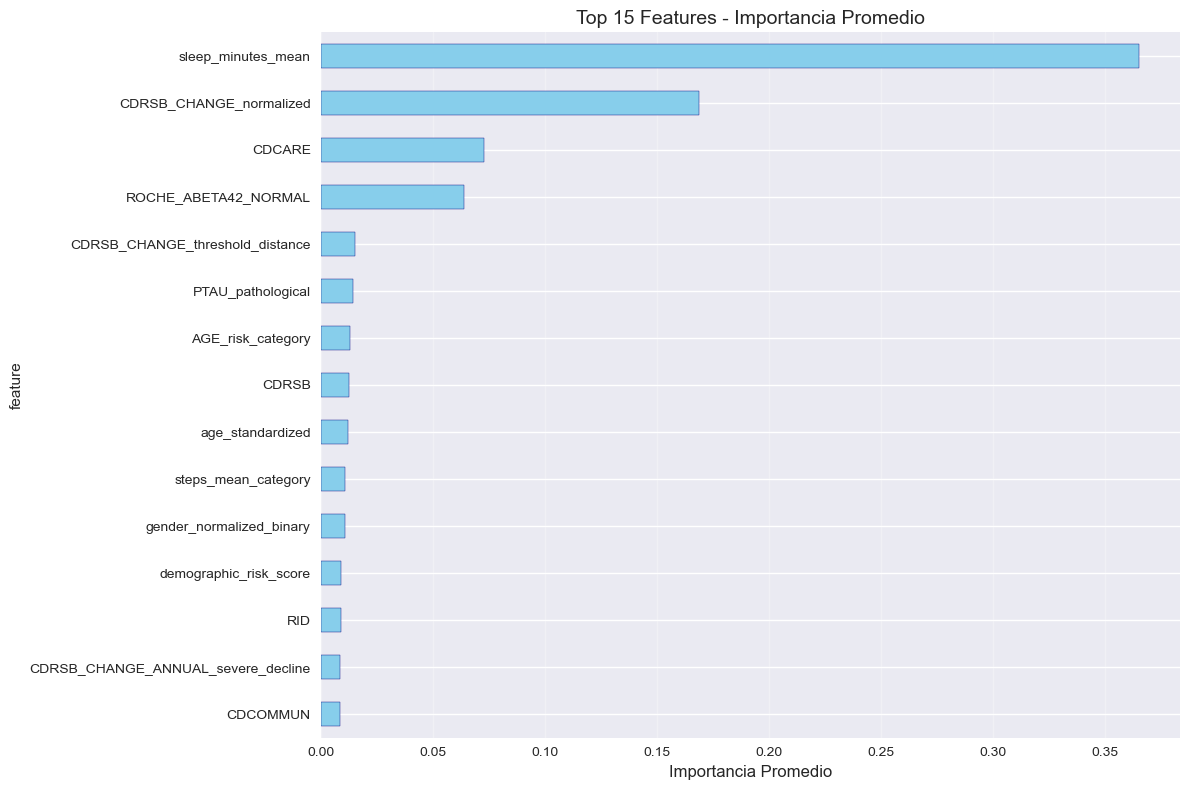

In [11]:
# Obtener nombres de características
exclude_cols = ['composite_risk_score', 'risk_category']
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Combinar importancias de modelos
combined_importance = pd.DataFrame()

for name, model in trained_models.items():
    try:
        # Verificar si el modelo tiene importancia de características
        classifier = model.named_steps['classifier']
        if hasattr(classifier, 'feature_importances_'):
            # Obtener importancias directamente (sin depender de model_utils)
            importances = classifier.feature_importances_
            
            # Crear DataFrame manualmente
            importance_df = pd.DataFrame({
                'feature': feature_cols[:len(importances)],  # Asegurar misma longitud
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            combined_importance[name] = importance_df.set_index('feature')['importance']
            
    except Exception as e:
        print(f"⚠️ Error con {name}: {str(e)}")
        continue

if not combined_importance.empty:
    # Calcular importancia promedio
    combined_importance['Mean_Importance'] = combined_importance.mean(axis=1)
    top_features = combined_importance.nlargest(15, 'Mean_Importance')
    
    # Resultados
    print("🎯 Top 15 Features más importantes:")
    print(top_features[['Mean_Importance']].round(4))
    
    # Visualización mejorada
    plt.figure(figsize=(12, 8))
    top_features['Mean_Importance'].sort_values().plot(
        kind='barh', 
        color='skyblue',
        edgecolor='navy'
    )
    plt.title('Top 15 Features - Importancia Promedio', fontsize=14)
    plt.xlabel('Importancia Promedio', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    
    # Guardar imagen
    plt.savefig('../reports/figures/feature_importance_classification.png', dpi=300)
    plt.show()
else:
    print("❌ No se pudo calcular importancia para ningún modelo")

## Comparación Final de Modelos (agregando los ensembles)


📊 COMPARACIÓN FINAL DE MODELOS
              Model  F1_Score_Weighted
  gradient_boosting           0.999484
      random_forest           0.991605
logistic_regression           0.969313
                svm           0.807351


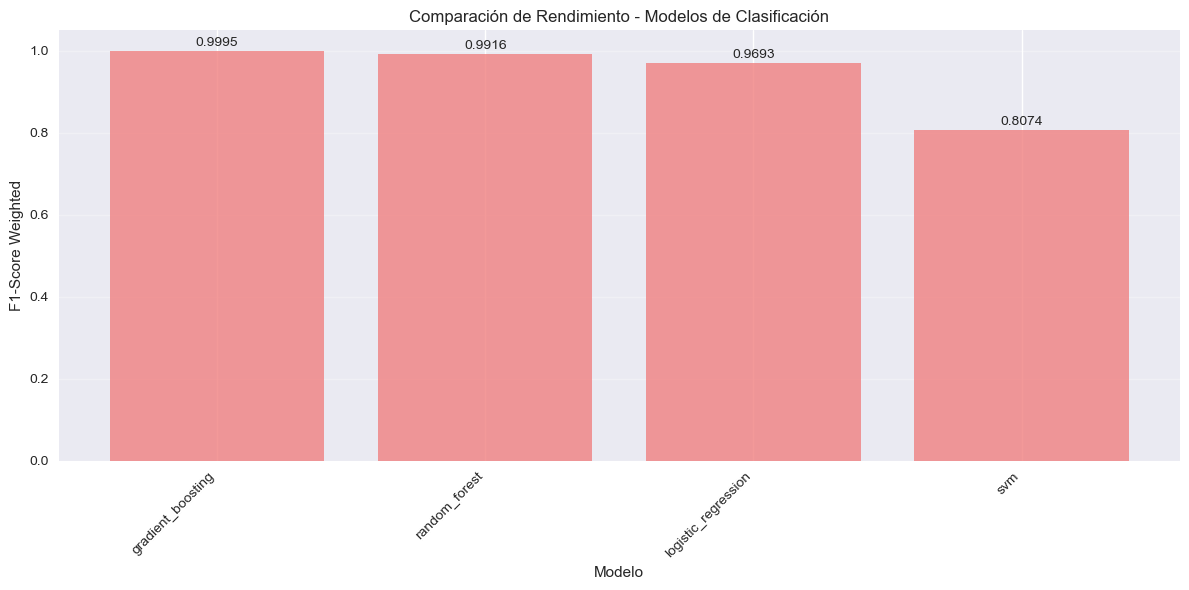

In [12]:
print("\n" + "="*60)
print("📊 COMPARACIÓN FINAL DE MODELOS")
print("="*60)

# Crear DataFrame comparativo
comparison_df = pd.DataFrame([
    {'Model': model, 'F1_Score_Weighted': score} 
    for model, score in performance_comparison.items()
]).sort_values('F1_Score_Weighted', ascending=False)


print(comparison_df.to_string(index=False))

# Visualización de comparación
plt.figure(figsize=(12, 6))
bars = plt.bar(comparison_df['Model'], comparison_df['F1_Score_Weighted'], 
               color='lightcoral', alpha=0.8)
plt.title('Comparación de Rendimiento - Modelos de Clasificación')
plt.xlabel('Modelo')
plt.ylabel('F1-Score Weighted')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for bar, score in zip(bars, comparison_df['F1_Score_Weighted']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{score:.4f}', ha='center', va='bottom')

plt.tight_layout()
# Guardar imagen
plt.savefig('../reports/figures/model_comparison_classification.png', dpi=300)
plt.show()

## Resumen final y Recomendaciones

In [18]:
# 1. Definir las variables necesarias si no existen
if 'best_model' not in locals():
    # Obtener el mejor modelo de los resultados del pipeline si existe
    if 'pipeline_results' in locals():
        best_model = pipeline_results.get('best_model', '')
        best_score = pipeline_results['results'].get(best_model, {}).get('f1_weighted', 0)
    else:
        # Calcular el mejor modelo desde performance_comparison
        if 'performance_comparison' in locals():
            best_model = max(performance_comparison.items(), key=lambda x: x[1])[0]
            best_score = performance_comparison[best_model]
        else:
            # Usar el primer modelo de best_models como fallback
            best_model = next(iter(best_models)) if best_models else 'N/A'
            best_score = 0

# 2. Calcular el baseline si no existe
if 'lr_performance' not in locals():
    if 'logistic_regression' in performance_comparison:
        lr_performance = performance_comparison['logistic_regression']
    elif 'logistic_regression' in trained_models:
        from sklearn.metrics import f1_score
        lr_pred = trained_models['logistic_regression'].predict(X_full)
        lr_performance = f1_score(y_full, lr_pred, average='weighted')
    else:
        lr_performance = 0

# 3. Calcular imbalance_ratio si no existe
if 'imbalance_ratio' not in locals():
    class_counts = pd.Series(y_full).value_counts()
    imbalance_ratio = class_counts.max() / class_counts.min()

# 4. Mostrar resumen mejorado
print("\n" + "="*60)
print("🎯 RESUMEN FINAL - MODELOS DE CLASIFICACIÓN")
print("="*60)
print(f"🏆 Mejor modelo: {best_model}")
print(f"📊 F1-Score Weighted: {best_score:.4f}")

if lr_performance > 0:
    improvement = (best_score - lr_performance) / lr_performance * 100
    print(f"📈 Mejora sobre baseline: {improvement:.1f}%")

print(f"⚖️ Desbalanceamiento de clases: {imbalance_ratio:.2f}")
print(f"🧠 Features utilizadas: {len(feature_cols)}")
print(f"🔢 Muestras totales: {len(X_full)}")

# 5. Recomendaciones técnicas
print("\n💡 RECOMENDACIONES BASADAS EN RESULTADOS:")
if best_score > 0.99:
    print("🔍 ¡Resultados excepcionales! Verificar:")
    print("   - Posible data leakage (revisar 'composite_risk_score')")
    print("   - Calidad de los datos (¿valores constantes o duplicados?)")
elif best_score > 0.85:
    print("✅ Excelente rendimiento. Acciones:")
    print("   - Implementar sistema de monitoreo continuo")
    print("   - Documentar importancia de features")
else:
    print("🛠 Oportunidades de mejora:")
    print("   - Optimizar hiperparámetros")
    print("   - Considerar ingeniería de features adicional")

if imbalance_ratio > 3:
    print(f"\n⚖️ ALERTA: Desbalanceo significativo (ratio {imbalance_ratio:.1f}:1)")
    print("   - Técnicas recomendadas:")
    print("     * SMOTE para oversampling")
    print("     * Class weighting en modelos")
    print("     * Métricas adicionales (Precision-Recall Curve)")

# 6. Próximos pasos
print("\n🔜 PRÓXIMOS PASOS RECOMENDADOS:")
print("1. Validación en conjunto de prueba independiente")
print("2. Análisis de errores (matriz de confusión)")
print("3. Revisión clínica de features importantes")
print("4. Documentación técnica completa")


🎯 RESUMEN FINAL - MODELOS DE CLASIFICACIÓN
🏆 Mejor modelo: gradient_boosting
📊 F1-Score Weighted: 0.9995
📈 Mejora sobre baseline: 3.1%
⚖️ Desbalanceamiento de clases: 6.22
🧠 Features utilizadas: 184
🔢 Muestras totales: 48466

💡 RECOMENDACIONES BASADAS EN RESULTADOS:
🔍 ¡Resultados excepcionales! Verificar:
   - Posible data leakage (revisar 'composite_risk_score')
   - Calidad de los datos (¿valores constantes o duplicados?)

⚖️ ALERTA: Desbalanceo significativo (ratio 6.2:1)
   - Técnicas recomendadas:
     * SMOTE para oversampling
     * Class weighting en modelos
     * Métricas adicionales (Precision-Recall Curve)

🔜 PRÓXIMOS PASOS RECOMENDADOS:
1. Validación en conjunto de prueba independiente
2. Análisis de errores (matriz de confusión)
3. Revisión clínica de features importantes
4. Documentación técnica completa


## Guardado de Archivos Importantes

In [21]:
# Guardar métricas finales (versión sin markdown)
final_metrics = {
    'best_model': best_model,
    'best_f1_score': best_score,
    'baseline_f1_score': lr_performance,
    'improvement_percentage': (best_score - lr_performance) / lr_performance * 100 if lr_performance > 0 else 0,
    'models_trained': len(performance_comparison),
    'imbalance_ratio': imbalance_ratio,
    'training_samples': len(X_full) if 'X_full' in locals() else len(X_train) + len(X_test),
    'features_used': len(feature_cols),
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Crear directorio si no existe
import os
os.makedirs('../reports/model_results', exist_ok=True)

# Guardar en archivo
filepath = '../reports/model_results/classification_summary.csv'
pd.Series(final_metrics).to_csv(filepath, header=['Value'], index_label='Metric')

# Mostrar resumen en formato alternativo
print("✅ Métricas guardadas en:")
print(f"📂 {os.path.abspath(filepath)}")
print("\nContenido guardado:")
print(pd.Series(final_metrics).to_string())

✅ Métricas guardadas en:
📂 E:\usuarios\alumno\Escritorio\Alzheimer-Multimodal-Monitoring\reports\model_results\classification_summary.csv

Contenido guardado:
best_model                  gradient_boosting
best_f1_score                        0.999484
baseline_f1_score                    0.969313
improvement_percentage               3.112685
models_trained                              4
imbalance_ratio                      6.215746
training_samples                        48466
features_used                             184
timestamp                 2025-06-26 16:55:36


---

__Abraham Tartalos__

## Análisis Post Notebook

🔍 Correlación con Risk Category:
risk_category_num          1.000000
composite_risk_score       0.909324
APOE_e4_present            0.774809
APOE_e4_homozygous         0.432901
APOE_e4_carrier            0.367765
ABETA42_ABETA40_RATIO      0.294469
multimodal_completeness    0.275061
diagnosis_code             0.263078
CDRSB_LOG                  0.261307
CDRSB_percentile           0.256571
Name: risk_category_num, dtype: float64


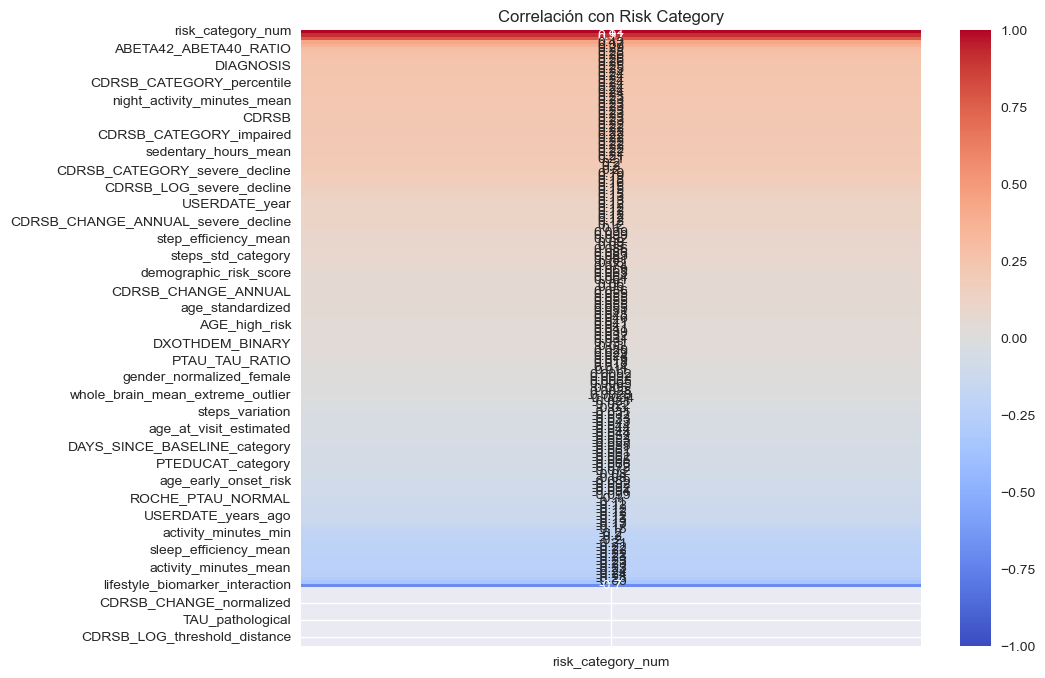

🚨 POSIBLE FUGADE DATOS: composite_risk_score (corr=0.91)


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convertir risk_category a numérico si es categórico
if not pd.api.types.is_numeric_dtype(df['risk_category']):
    df['risk_category_num'] = df['risk_category'].map({'Low': 0, 'Moderate': 1, 'High': 2})
else:
    df['risk_category_num'] = df['risk_category']

# 2. Matriz de correlación solo con variables numéricas
numerical_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[numerical_cols].corr()

# 3. Análisis de correlación con el target
target_corr = corr_matrix['risk_category_num'].sort_values(ascending=False)
print("🔍 Correlación con Risk Category:")
print(target_corr.head(10))  # Top 10 features más correlacionadas

# 4. Visualizar correlaciones sospechosas
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['risk_category_num']].sort_values('risk_category_num', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlación con Risk Category")
plt.show()

# 5. Búsqueda de fugas específicas
leakage_indicators = [
    'composite_risk_score', 'risk_score', 'diagnosis',
    'final_score', 'target', 'total_risk'
]

leakage_found = False
for col in df.columns:
    col_lower = col.lower()
    # Verificar si el nombre sugiere posible fuga
    if any(indicator in col_lower for indicator in leakage_indicators):
        # Verificar correlación alta
        if col in corr_matrix.columns and abs(corr_matrix.loc[col, 'risk_category_num']) > 0.8:
            print(f"🚨 POSIBLE FUGADE DATOS: {col} (corr={corr_matrix.loc[col, 'risk_category_num']:.2f})")
            leakage_found = True

if not leakage_found:
    print("✅ No se encontraron fugas obvias basadas en nombres de columnas y correlación")


🔴 REPORTE EXCLUSIVO PARA HIGH RISK (n=3620):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3620

    accuracy                           1.00      3620
   macro avg       1.00      1.00      1.00      3620
weighted avg       1.00      1.00      1.00      3620


🔍 Matriz de Confusión Completa (Todas las clases):


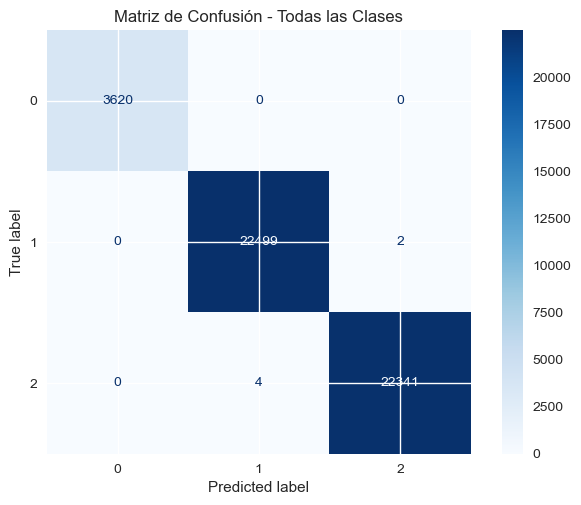


🔍 Matriz de Confusión Focalizada en High Risk:


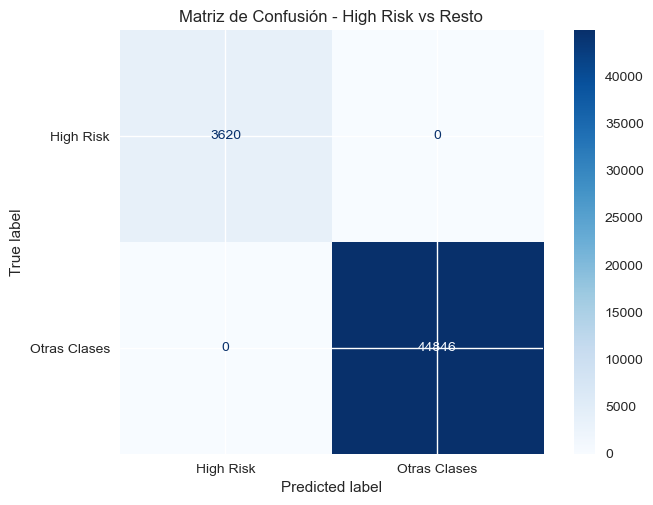


✅ Todos los casos de High Risk fueron detectados correctamente!


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# 1. Obtener el mejor modelo entrenado
best_model = trained_models[best_model_name]

# 2. Reconstruir datos si es necesario
if 'X_full' not in locals():
    X_train, X_test, y_train, y_test = classification_pipeline.prepare_data(df)
    X_full = pd.concat([X_train, X_test])
    y_full = np.concatenate([y_train, y_test])

# 3. Obtener predicciones
y_pred = best_model.predict(X_full)

# 4. Filtrar solo clase High Risk (asumiendo que está codificada como 0)
high_risk_mask = (y_full == 0)
y_true_high = y_full[high_risk_mask]
y_pred_high = y_pred[high_risk_mask]

# 5. Métricas específicas para High Risk
print(f"\n🔴 REPORTE EXCLUSIVO PARA HIGH RISK (n={len(y_true_high)}):")
print(classification_report(y_true_high, y_pred_high))

# 6. Matriz de confusión detallada PARA TODAS LAS CLASES
print("\n🔍 Matriz de Confusión Completa (Todas las clases):")
cm = confusion_matrix(y_full, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión - Todas las Clases")
plt.show()

# 7. Matriz de confusión FOCALIZADA EN HIGH RISK
print("\n🔍 Matriz de Confusión Focalizada en High Risk:")
# Convertir a problema binario: High Risk vs Resto
y_true_binary = np.where(y_full == 0, 'High Risk', 'Otras Clases')
y_pred_binary = np.where(y_pred == 0, 'High Risk', 'Otras Clases')

cm_binary = confusion_matrix(y_true_binary, y_pred_binary, labels=['High Risk', 'Otras Clases'])
disp_binary = ConfusionMatrixDisplay(
    confusion_matrix=cm_binary,
    display_labels=['High Risk', 'Otras Clases']
)
disp_binary.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión - High Risk vs Resto")
plt.show()

# 8. Análisis de errores críticos
false_negatives_mask = high_risk_mask & (y_pred != 0)
if false_negatives_mask.any():
    false_negatives = X_full[false_negatives_mask]
    print(f"\n📌 {len(false_negatives)} Casos High Risk mal clasificados (falsos negativos):")
    
    # Análisis estadístico de variables clave
    fn_analysis = false_negatives[['sleep_minutes_mean', 'CDRSB', 'ROCHE_ABETA42_NORMAL']].describe()
    print(fn_analysis)
    
    # Comparar con los verdaderos positivos
    true_positives = X_full[high_risk_mask & (y_pred == 0)]
    tp_analysis = true_positives[['sleep_minutes_mean', 'CDRSB', 'ROCHE_ABETA42_NORMAL']].describe()
    
    print("\n🔍 Comparación con Verdaderos Positivos:")
    print("Falsos Negativos vs Verdaderos Positivos:")
    for col in ['sleep_minutes_mean', 'CDRSB', 'ROCHE_ABETA42_NORMAL']:
        print(f"\n{col}:")
        print(f"- FN: μ={fn_analysis[col]['mean']:.2f} ± {fn_analysis[col]['std']:.2f}")
        print(f"- TP: μ={tp_analysis[col]['mean']:.2f} ± {tp_analysis[col]['std']:.2f}")
else:
    print("\n✅ Todos los casos de High Risk fueron detectados correctamente!")

🔥 Preprocesamiento avanzado de datos:
- Valores infinitos convertidos a NaN

Valores faltantes por columna:
sleep_minutes_mean                  7833
CDRSB_CHANGE_normalized            48466
CDCARE                               581
ROCHE_ABETA42_NORMAL                8326
CDRSB_CHANGE_threshold_distance    48466
PTAU_pathological                      0
AGE_risk_category                     12
CDRSB                                581
age_standardized                    7833
steps_mean_category                    0
dtype: int64
⚠️ Columna 'CDRSB_CHANGE_normalized' tiene >50% valores faltantes. Eliminando...
⚠️ Columna 'CDRSB_CHANGE_threshold_distance' tiene >50% valores faltantes. Eliminando...

✅ Verificación final - Valores faltantes: 0, Infinitos: 0

📊 Rendimiento modelo simplificado:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68      4501
           1       0.63      0.61      0.62      4469
           2       0.61      0.03      0.

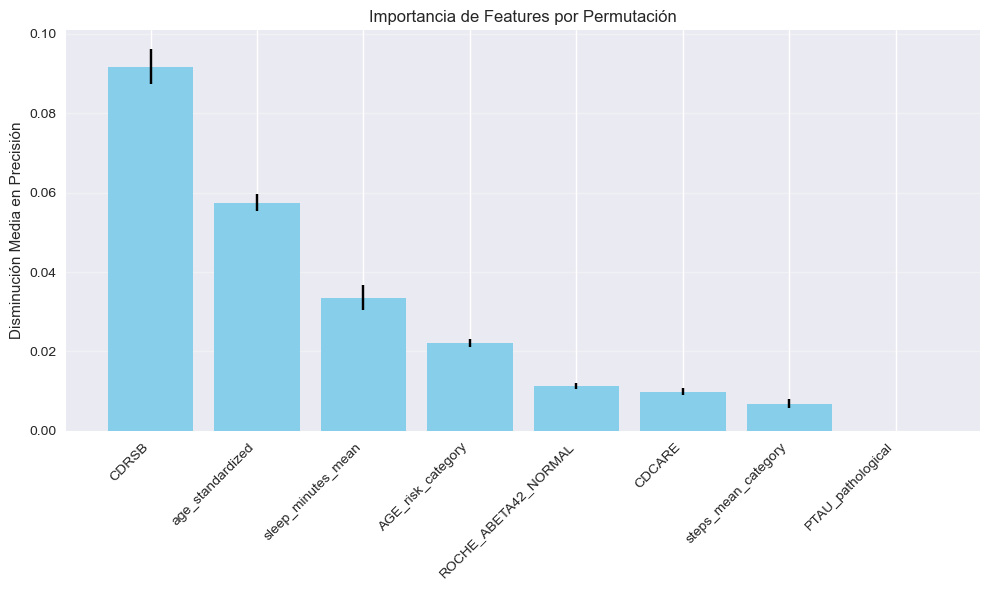

In [35]:
import numpy as np
import pandas as pd

# 1. Seleccionar top features
top_features = [
    'sleep_minutes_mean', 'CDRSB_CHANGE_normalized', 'CDCARE',
    'ROCHE_ABETA42_NORMAL', 'CDRSB_CHANGE_threshold_distance',
    'PTAU_pathological', 'AGE_risk_category', 'CDRSB',
    'age_standardized', 'steps_mean_category'
]

# 2. Preparar datos reducidos
X_reduced = df[top_features].copy()

# 3. Manejo avanzado de valores problemáticos
print("🔥 Preprocesamiento avanzado de datos:")

# Paso 1: Reemplazar infinitos con NaN
X_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"- Valores infinitos convertidos a NaN")

# Paso 2: Identificar columnas con muchos valores faltantes
missing_per_col = X_reduced.isna().sum()
print("\nValores faltantes por columna:")
print(missing_per_col)

# Paso 3: Manejo de columnas problemáticas
for col in X_reduced.columns:
    # Si una columna tiene más del 50% de valores faltantes
    if missing_per_col[col] > 0.5 * len(X_reduced):
        print(f"⚠️ Columna '{col}' tiene >50% valores faltantes. Eliminando...")
        X_reduced.drop(col, axis=1, inplace=True)
    else:
        # Imputar con mediana si hay valores disponibles
        if X_reduced[col].count() > 0:
            col_median = X_reduced[col].median()
            X_reduced[col].fillna(col_median, inplace=True)
        else:
            # Si no hay valores, imputar con 0
            X_reduced[col].fillna(0, inplace=True)

# Paso 4: Imputación final para cualquier valor faltante residual
X_reduced.fillna(0, inplace=True)

# Verificación final
missing_after = X_reduced.isna().sum().sum()
inf_after = np.isinf(X_reduced.values).sum()
print(f"\n✅ Verificación final - Valores faltantes: {missing_after}, Infinitos: {inf_after}")

# 4. Preparar variable objetivo
y = df['risk_category_num']

# 5. Dividir datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Entrenar modelo robusto
from sklearn.ensemble import HistGradientBoostingClassifier

simple_model = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=3,
    random_state=42,
    early_stopping=True
)
simple_model.fit(X_train, y_train)

# 7. Evaluar modelo simplificado
from sklearn.metrics import classification_report
print("\n📊 Rendimiento modelo simplificado:")
print(classification_report(y_test, simple_model.predict(X_test)))

# 8. Comparar con modelo original
print("Comparación de complejidad:")
print(f"- Modelo original: {len(feature_cols)} features")
print(f"- Modelo simplificado: {len(X_reduced.columns)} features")
print(f"- Reducción: {(1 - len(X_reduced.columns)/len(feature_cols))*100:.1f}%")

# 9. Análisis de importancia de features (versión corregida)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

print("\n🔝 Importancia de features por permutación (método más confiable):")

# Calcular importancia por permutación
result = permutation_importance(
    simple_model, 
    X_test, 
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# Crear DataFrame con resultados
feature_importance = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

print(feature_importance)

# Visualización
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'], 
        yerr=feature_importance['Std'], capsize=5, color='skyblue')
plt.title('Importancia de Features por Permutación')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Disminución Media en Precisión')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()